In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

In [2]:
def convert_to_int(x):
    try:
        if isinstance(x, str) or isinstance(x, float):
            return int(x)
        else:
            return x
    except ValueError:
        return x

In [3]:
# I would like to add more features. I will be focusing on tcp.seq :
# 1. Large, unexplained jumps in TCP sequence numbers can indicate packet loss or reordering. This might happen due to network congestion, faulty hardware, or malicious activities disrupting normal traffic flow.
# 2. If we observe packets with the same sequence number but different payload data, it could be indicative of a session hijacking attack or man-in-the-middle attack, where an attacker is trying to inject malicious packets into a legitimate TCP stream.
# 3. Patterns like regular gaps or strange distributions in sequence numbers might suggest an attacker is trying to infer the state of a TCP session or manipulate TCP traffic.
# 4. Anomalous sequence number patterns can also be associated with port scanning activities, where attackers send TCP packets to various ports to discover services they can exploit.
# 5. In a SYN flooding attack, attackers exploit the TCP handshake mechanism by sending a large number of SYN packets with spoofed IP addresses. An unusual pattern in sequence numbers, combined with a high volume of SYN packets, could indicate such an attack.
# 6. RST packets with sequence numbers that don't align with the expected flow of the ongoing TCP session might be an attempt to prematurely close a TCP connection, potentially indicating a denial-of-service attack or other malicious disruptions.
df = pd.read_csv('../attack-sample-3m.csv')

/tmp/ipykernel_580636/2804803071.py:8: DtypeWarning: Columns (0,1,3,10,11,13,14,15,18,19,20,21,22,24,25,26,27,28,30,31,32,33,34,35,36,37,42,44,50,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../attack-sample-3m.csv')


In [4]:
df.columns

Index(['frame.number', 'frame.len', 'frame.time', 'frame.time_epoch',
       'frame.protocols', 'eth.src', 'eth.dst', 'eth.type', 'ip.src', 'ip.dst',
       'ip.len', 'ip.ttl', 'ip.flags', 'ip.frag_offset', 'ip.proto',
       'ip.version', 'ip.dsfield', 'ip.checksum', 'tcp.srcport', 'tcp.dstport',
       'tcp.len', 'tcp.seq', 'tcp.ack', 'tcp.flags', 'tcp.flags.syn',
       'tcp.flags.ack', 'tcp.flags.fin', 'tcp.flags.reset', 'tcp.window_size',
       'tcp.checksum', 'tcp.stream', 'udp.srcport', 'udp.dstport',
       'udp.length', 'udp.checksum', 'icmp.type', 'icmp.code', 'icmp.checksum',
       'http.request.method', 'http.request.uri', 'http.request.version',
       'http.request.full_uri', 'http.response.code', 'http.user_agent',
       'http.content_length_header', 'http.content_type', 'http.cookie',
       'http.host', 'http.referer', 'http.location', 'http.authorization',
       'http.connection', 'dns.qry.name', 'dns.qry.type', 'dns.qry.class',
       'dns.flags.response', 'dns.f

In [5]:
columns_to_keep = ['frame.number', 'frame.time', 'frame.protocols', 'tcp.seq', 'tcp.stream', 'tcp.srcport','tcp.dstport', 'udp.srcport', 'udp.dstport', 'tcp.flags.syn', 'tcp.flags.reset', 'ip.src', 'ip.dst']

In [6]:
df = df[columns_to_keep]
df.shape

(3000000, 13)

In [7]:
df['tcp.seq'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 3000000 entries, 0 to 2999999
Series name: tcp.seq
Non-Null Count    Dtype 
--------------    ----- 
2996269 non-null  object
dtypes: object(1)
memory usage: 22.9+ MB


In [8]:
df['tcp.seq'].head(15)

0      95785.0
1        588.0
2          NaN
3          0.0
4        187.0
5      11578.0
6     112416.0
7     161575.0
8       1290.0
9      59582.0
10     13156.0
11     12722.0
12      5553.0
13     28604.0
14     21517.0
Name: tcp.seq, dtype: object

In [9]:
df['tcp.seq'].value_counts()

tcp.seq
1.0         146934
0.0         104081
1449.0       15276
2897.0        1656
3312.0         803
             ...  
276528.0         1
833490.0         1
329929.0         1
187882.0         1
348866.0         1
Name: count, Length: 292867, dtype: int64

In [10]:
df.loc[df['tcp.seq'].apply(lambda x: not isinstance(x, float))]

,frame.number,frame.time,frame.protocols,tcp.seq,tcp.stream,tcp.srcport,tcp.dstport,udp.srcport,udp.dstport,tcp.flags.syn,tcp.flags.reset,ip.src,ip.dst
2039808,5025081,"Jun 4, 2023 11:54:48.903692000 EDT",eth:ethertype:ip:tcp:http,9681,89649,59544,80,NaN,NaN,0,0,10.20.30.103,10.20.30.101
2039809,3374184,"Jun 4, 2023 11:48:50.351842000 EDT",eth:ethertype:ip:tcp:http,14443,82366,40352,80,NaN,NaN,0,0,10.20.30.103,10.20.30.101
2039810,3137260,"Jun 4, 2023 11:48:00.518732000 EDT",eth:ethertype:ip:tcp,6283,81239,56466,80,NaN,NaN,0,0,10.20.30.103,10.20.30.101
2039811,1295432,"Jun 4, 2023 11:35:55.144273000 EDT",eth:ethertype:ip:tcp:http,9331,73352,57504,80,NaN,NaN,0,0,10.20.30.103,10.20.30.101
2039812,4616984,"Jun 4, 2023 11:52:59.232568000 EDT",eth:ethertype:ip:tcp:http,25165,87610,40900,80,NaN,NaN,0,0,10.20.30.103,10.20.30.101
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2047995,1127451,"Jun 4, 2023 11:34:42.752891000 EDT",eth:ethertype:ip:tcp:http,11587,72529,45090,80,NaN,NaN,0,0,10.20.30.103,10.20.30.101
2047996,5347165,"Jun 4, 2023 12:08:21.131228000 EDT",eth:ethertype:ip:tcp,86062,91192,80,58622,NaN,NaN,0,0,10.20.30.101,10.20.30.103
2047997,900431,"Jun 4, 2023 11:33:08.888339000 EDT",eth:ethertype:ip:tcp:http:data-text-lines,28668,71419,80,57996,NaN,NaN,0,0,10.20.30.101,10.20.30.103
2047998,4676276,"Jun 4, 2023 11:53:13.465266000 EDT",eth:ethertype:ip:tcp:http:data-text-lines,95067,87980,80,42164,NaN,NaN,0,0,10.20.30.101,10.20.30.103


In [11]:
df['tcp.seq'] = df['tcp.seq'].apply(convert_to_int)

In [12]:
df.loc[df['tcp.seq'].apply(lambda x: not isinstance(x, int))]

,frame.number,frame.time,frame.protocols,tcp.seq,tcp.stream,tcp.srcport,tcp.dstport,udp.srcport,udp.dstport,tcp.flags.syn,tcp.flags.reset,ip.src,ip.dst
2,6220814,"Jun 4, 2023 12:49:03.684361000 EDT",eth:ethertype:ip:udp:dns,NaN,NaN,NaN,NaN,43998.0,53.0,NaN,NaN,10.20.30.103,10.20.30.1
821,5660535,"Jun 4, 2023 12:31:19.537102000 EDT",eth:ethertype:ip:udp:dns,NaN,NaN,NaN,NaN,37982.0,53.0,NaN,NaN,10.20.30.103,10.20.30.1
2943,5302458,"Jun 4, 2023 12:03:54.649791000 EDT",eth:ethertype:ip:udp:dns,NaN,NaN,NaN,NaN,44776.0,53.0,NaN,NaN,10.20.30.103,10.20.30.1
3480,5613249,"Jun 4, 2023 12:27:47.429178000 EDT",eth:ethertype:ip:udp:dns,NaN,NaN,NaN,NaN,39117.0,53.0,NaN,NaN,10.20.30.103,10.20.30.1
3614,6053987,"Jun 4, 2023 12:43:18.556629000 EDT",eth:ethertype:ip:icmp:data,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.20.30.103,10.20.30.101
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2992803,5310352,"Jun 4, 2023 12:04:43.218403000 EDT",eth:ethertype:ip:udp:dns,NaN,NaN,NaN,NaN,58316.0,53.0,NaN,NaN,10.20.30.103,10.20.30.1
2993072,5814079,"Jun 4, 2023 12:32:52.456929000 EDT",eth:ethertype:ip:icmp:data,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.20.30.101,10.20.30.103
2996716,5958091,"Jun 4, 2023 12:33:44.468790000 EDT",eth:ethertype:ip:icmp:data,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.20.30.103,10.20.30.101
2998023,5568365,"Jun 4, 2023 12:24:22.385555000 EDT",eth:ethertype:ip:icmp:data,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.20.30.103,10.20.30.101


In [13]:
df = df.dropna(subset = ['tcp.seq'])

In [14]:
df.loc[df['tcp.seq'].apply(lambda x: not isinstance(x, int))]

,frame.number,frame.time,frame.protocols,tcp.seq,tcp.stream,tcp.srcport,tcp.dstport,udp.srcport,udp.dstport,tcp.flags.syn,tcp.flags.reset,ip.src,ip.dst
2042160,frame.number,frame.time,frame.protocols,tcp.seq,tcp.stream,tcp.srcport,tcp.dstport,udp.srcport,udp.dstport,tcp.flags.syn,tcp.flags.reset,ip.src,ip.dst


In [15]:
df = df[df['tcp.seq'] != 'tcp.seq']

In [ ]:
# # I would like to see the distribution of this feature:
# fig = px.histogram(df, x='tcp.seq',title='Distribution of TCP Sequence Numbers' )

# fig.update_layout(
#     xaxis_title='TCP Sequence Number',
#     yaxis_title='Frequency',
#     bargap=0.2  # Adjust the gap between bars
# )

# # Show the plot
# fig.show()

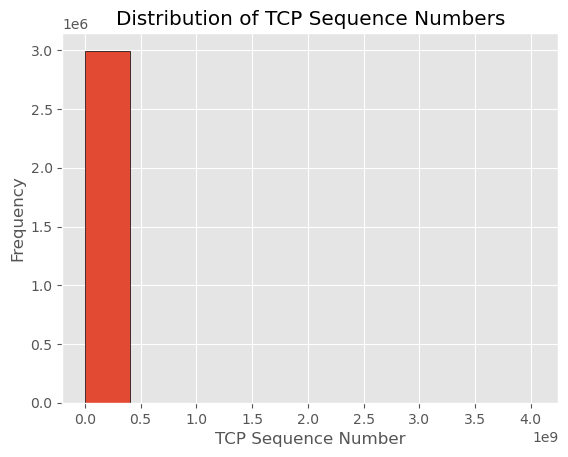

In [17]:
plt.hist(df['tcp.seq'], bins=10, edgecolor='black')


plt.title('Distribution of TCP Sequence Numbers')
plt.xlabel('TCP Sequence Number')
plt.ylabel('Frequency')

plt.style.use('ggplot')

# Show the plot
plt.show()